## IMPORTS AND SETUP

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import glob
import warnings
warnings.filterwarnings('ignore')

# Machine Learning libraries
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
import joblib

# Set paths
DATA_PATH = "/kaggle/input/redd-dataset/redd"
OUTPUT_PATH = "/kaggle/working/house2_results/"

# Create output directory
os.makedirs(OUTPUT_PATH, exist_ok=True)

# POWER WINDOW CONFIGURATION

In [2]:
class ConfigHouse2:
    
    HOUSE_NUMBER = 2
    
    # Appliances present in House 2 (from your data analysis)
    SELECTED_APPLIANCES = [
        'dish_washer',
        'electric_stove', 
        'fridge',
        'microwave',
        'washer_dryer'
    ]
    
    
    POWER_WINDOWS_W = {
        'dish_washer': (1200, 1800),     # 1.2-1.8 kW
        'electric_stove': (1500, 3500),  # 1.5-3.5 kW
        'fridge': (100, 300),            # 0.1-0.3 kW (continuous operation)
        'microwave': (800, 1200),        # 0.8-1.2 kW
        'washer_dryer': (2000, 5000),    # 2-5 kW (when heating)
    }
    
    # Convert to kW for our data (which is in kW)
    POWER_WINDOWS = {k: (v[0]/1000, v[1]/1000) for k, v in POWER_WINDOWS_W.items()}
    
    # Threshold values (OPM) as in paper
    THRESHOLDS = [5, 10, 20, 30, 40, 50]
    
    # Training parameters
    RANDOM_STATE = 42
    TEST_SIZE = 0.2
    
    # Performance metrics focus
    METRICS = ['macro', 'weighted']

print(f"Setup complete for House {ConfigHouse2.HOUSE_NUMBER}!")
print(f"Dataset path: {DATA_PATH}")
print(f"Output path: {OUTPUT_PATH}")
print(f"Selected appliances: {ConfigHouse2.SELECTED_APPLIANCES}")
print("\nPower Windows (in kW):")
for app, (low, high) in ConfigHouse2.POWER_WINDOWS.items():
    print(f"  {app:15s}: [{low:.3f} kW, {high:.3f} kW]")

Setup complete for House 2!
Dataset path: /kaggle/input/redd-dataset/redd
Output path: /kaggle/working/house2_results/
Selected appliances: ['dish_washer', 'electric_stove', 'fridge', 'microwave', 'washer_dryer']

Power Windows (in kW):
  dish_washer    : [1.200 kW, 1.800 kW]
  electric_stove : [1.500 kW, 3.500 kW]
  fridge         : [0.100 kW, 0.300 kW]
  microwave      : [0.800 kW, 1.200 kW]
  washer_dryer   : [2.000 kW, 5.000 kW]


# DATA LOADER

In [3]:
class REDDDataLoaderHouse2:
    """Loads and correctly preprocesses REDD dataset for House 2"""
    
    def __init__(self, data_path, house_number=2):
        self.data_path = data_path
        self.house_number = house_number
        self.selected_appliances = ConfigHouse2.SELECTED_APPLIANCES
        
    def _load_and_combine_files(self):
        """Load all CSV files for House 2"""
        pattern = os.path.join(self.data_path, f'*house{self.house_number}*.csv')
        csv_files = glob.glob(pattern)
        
        if not csv_files:
            raise FileNotFoundError(f"No CSV files found for house {self.house_number}")
        
        print(f"Found {len(csv_files)} files for house {self.house_number}")
        
        dfs = []
        for file in sorted(csv_files):
            try:
                df = pd.read_csv(file)
                dfs.append(df)
                print(f"  Loaded: {os.path.basename(file)} ({len(df)} rows, {len(df.columns)} cols)")
            except Exception as e:
                print(f"  Error reading {file}: {e}")
        
        if not dfs:
            raise ValueError("No valid data loaded")
        
        # Combine all dataframes
        combined_df = pd.concat(dfs, ignore_index=True)
        
        # Standardize column names
        combined_df.columns = [col.strip().lower().replace(' ', '_').replace('-', '_') 
                              for col in combined_df.columns]
        
        return combined_df
    
    def _correct_units_and_clean(self, df):
        """Correct units and clean data - Data is in kW, not W"""
        print("\n" + "="*80)
        print("UNIT CORRECTION AND CLEANING")
        print("="*80)
        
        df_clean = df.copy()
        
        # Remove any index columns
        if 'unnamed:_0' in df_clean.columns:
            df_clean = df_clean.drop(columns=['unnamed:_0'])
        
        # Handle missing values
        df_clean = df_clean.fillna(0)
        
        # Ensure numeric types
        for col in df_clean.columns:
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
        df_clean = df_clean.fillna(0)
        
        # Remove negative values (set to 0)
        numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
        df_clean[numeric_cols] = df_clean[numeric_cols].clip(lower=0)
        
        # Convert to kW if needed (data appears to already be in kW)
        # Based on your diagnostics: main meter max 3.2 kW = 3200W - REASONABLE
        
        print("\nFINAL DATA STATISTICS (in kW):")
        print(f"{'Column':<20} {'Min':<10} {'Max':<10} {'Mean':<10} {'Std':<10} {'% Non-zero':<10}")
        print("-"*80)
        
        for col in df_clean.columns:
            if col in numeric_cols:
                data = df_clean[col].values
                min_val = data.min()
                max_val = data.max()
                mean_val = data.mean()
                std_val = data.std()
                pct_nonzero = (data > 0.01).sum() / len(data) * 100  # >10W threshold
                
                print(f"{col:<20} {min_val:<10.3f} {max_val:<10.3f} {mean_val:<10.3f} "
                      f"{std_val:<10.3f} {pct_nonzero:<10.1f}")
        
        return df_clean
    
    def load_house_data(self):
        """Main method to load and preprocess data"""
        print(f"\nProcessing House {self.house_number}...")
        
        # Step 1: Load raw data
        raw_df = self._load_and_combine_files()
        
        # Step 2: Correct units and clean
        final_df = self._correct_units_and_clean(raw_df)
        
        print(f"\n✅ Successfully loaded {len(final_df)} samples from House {self.house_number}")
        print(f"   Data shape: {final_df.shape}")
        print(f"   Columns: {list(final_df.columns)}")
        
        return final_df

# DATA VISUALIZATION

In [4]:
def plot_power_distributions(df, title="Power Distributions (kW)"):
    """Plot histograms of power values"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    # Plot main meter first
    ax = axes[0]
    if 'main' in df.columns:
        data = df['main'].values
        # Filter out very low values for better visualization
        non_zero = data[data > 0.01]
        ax.hist(non_zero, bins=50, alpha=0.7, edgecolor='black')
        ax.set_title('Main Meter (Aggregate)')
        ax.set_xlabel('Power (kW)')
        ax.set_ylabel('Frequency')
        ax.grid(True, alpha=0.3)
    
    # Plot individual appliances
    appliances = ['dish_washer', 'electric_stove', 'fridge', 'microwave', 'washer_dryer']
    for idx, col in enumerate(appliances):
        if idx < len(axes) - 1:
            ax = axes[idx + 1]
            if col in df.columns:
                data = df[col].values
                # Filter out zeros for better visualization
                non_zero = data[data > 0.001]
                if len(non_zero) > 0:
                    ax.hist(non_zero, bins=50, alpha=0.7, edgecolor='black')
                    ax.set_title(f'{col}')
                    ax.set_xlabel('Power (kW)')
                    ax.set_ylabel('Frequency')
                    ax.grid(True, alpha=0.3)
                else:
                    ax.text(0.5, 0.5, 'All zeros/low', ha='center', va='center', transform=ax.transAxes)
            else:
                ax.text(0.5, 0.5, 'Not in data', ha='center', va='center', transform=ax.transAxes)
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    return fig

def analyze_appliance_behavior(df):
    """Analyze appliance ON/OFF patterns"""
    print("\n" + "="*80)
    print("APPLIANCE BEHAVIOR ANALYSIS")
    print("="*80)
    
    results = {}
    threshold_kw = 0.01  # 10W threshold for "ON"
    
    for appliance in ConfigHouse2.SELECTED_APPLIANCES:
        if appliance in df.columns:
            data = df[appliance].values
            
            # Statistics
            total_samples = len(data)
            on_samples = (data > threshold_kw).sum()
            pct_on = on_samples / total_samples * 100
            
            # Power statistics when ON
            on_power = data[data > threshold_kw]
            if len(on_power) > 0:
                mean_power = on_power.mean()
                std_power = on_power.std()
                min_power = on_power.min()
                max_power = on_power.max()
            else:
                mean_power = std_power = min_power = max_power = 0
            
            results[appliance] = {
                'total_samples': total_samples,
                'on_samples': on_samples,
                'pct_on': pct_on,
                'mean_power_kw': mean_power,
                'std_power_kw': std_power,
                'min_power_kw': min_power,
                'max_power_kw': max_power
            }
            
            print(f"\n{appliance:20s}:")
            print(f"  ON samples: {on_samples:,} ({pct_on:.1f}%)")
            print(f"  Power when ON: {mean_power:.3f} ± {std_power:.3f} kW")
            print(f"  Power range: [{min_power:.3f}, {max_power:.3f}] kW")
            
            # Compare with expected windows
            if appliance in ConfigHouse2.POWER_WINDOWS:
                low, high = ConfigHouse2.POWER_WINDOWS[appliance]
                within_window = ((on_power >= low) & (on_power <= high)).sum()
                pct_within = within_window / len(on_power) * 100 if len(on_power) > 0 else 0
                print(f"  Within expected window [{low:.3f}, {high:.3f}] kW: {pct_within:.1f}%")
    
    return results

# APPLIANCE STATE CREATION

In [5]:
def create_appliance_states_corrected(df, power_windows, verbose=True):
    """Create binary states based on power windows - CORRECTED VERSION"""
    df_states = df.copy()
    
    if verbose:
        print("\n" + "="*80)
        print("CREATING APPLIANCE STATES (Corrected)")
        print("="*80)
    
    for appliance, (lower, upper) in power_windows.items():
        if appliance in df_states.columns:
            # Create binary state: 1 if power within window, 0 otherwise
            # Also consider if power > 0.01 kW (10W) as ON
            state_series = ((df_states[appliance] >= lower) & 
                           (df_states[appliance] <= upper)).astype(int)
            df_states[f"{appliance}_state"] = state_series
            
            if verbose:
                on_samples = state_series.sum()
                pct_on = on_samples / len(df_states) * 100
                print(f"{appliance:20s}: {on_samples:7,d} ON samples ({pct_on:.1f}%)")
                print(f"  Window: [{lower:.3f} kW, {upper:.3f} kW]")
    
    return df_states

def create_multiclass_labels_corrected(df_states, selected_appliances, threshold=10, verbose=True):
    """Create multiclass labels with thresholding - CORRECTED"""
    
    # Get state columns
    state_columns = [f"{app}_state" for app in selected_appliances 
                     if f"{app}_state" in df_states.columns]
    
    if not state_columns:
        raise ValueError("No state columns found!")
    
    # Sort for consistency
    state_columns = sorted(state_columns)
    
    # Create binary combination string
    df_states['binary_combination'] = df_states[state_columns].astype(str).agg(''.join, axis=1)
    
    # Apply thresholding
    combination_counts = df_states['binary_combination'].value_counts()
    valid_combinations = combination_counts[combination_counts >= threshold].index
    df_filtered = df_states[df_states['binary_combination'].isin(valid_combinations)].copy()
    
    if verbose:
        print(f"\nThresholding Analysis (Threshold = {threshold}):")
        print(f"Total samples: {len(df_states):,}")
        print(f"Unique combinations: {len(combination_counts)}")
        print(f"Valid combinations (≥{threshold}): {len(valid_combinations)}")
        print(f"Samples after thresholding: {len(df_filtered):,} ({len(df_filtered)/len(df_states)*100:.1f}%)")
        
        # Show top combinations
        print("\nTop 10 Appliance Combinations:")
        top_combos = combination_counts.head(10)
        for combo, count in top_combos.items():
            # Decode binary string
            states = []
            apps = [app.replace('_state', '') for app in state_columns]
            for i, app in enumerate(apps):
                if i < len(combo):
                    state = "ON" if combo[i] == '1' else "OFF"
                    states.append(f"{app[:3]}:{state}")
            state_str = " | ".join(states)
            print(f"  {combo}: {state_str} - {count:7,d} samples")
    
    # Encode labels
    label_encoder = LabelEncoder()
    df_filtered['label'] = label_encoder.fit_transform(df_filtered['binary_combination'])
    
    # Features: only aggregate power (main)
    X = df_filtered[['main']].values.astype(np.float32)
    y = df_filtered['label'].values
    
    return X, y, label_encoder, df_filtered

# LOAD DATA AND RUN DIAGNOSTICS


LOADING HOUSE 2 DATA

Processing House 2...
Found 7 files for house 2
  Loaded: redd_house2_0.csv (34429 rows, 8 cols)
  Loaded: redd_house2_1.csv (48110 rows, 8 cols)
  Loaded: redd_house2_2.csv (29378 rows, 8 cols)
  Loaded: redd_house2_3.csv (24010 rows, 8 cols)
  Loaded: redd_house2_4.csv (33612 rows, 8 cols)
  Loaded: redd_house2_5.csv (99258 rows, 8 cols)
  Loaded: redd_house2_6.csv (23266 rows, 8 cols)

UNIT CORRECTION AND CLEANING

FINAL DATA STATISTICS (in kW):
Column               Min        Max        Mean       Std        % Non-zero
--------------------------------------------------------------------------------
dish_washer          0.000      1457.000   10.780     105.096    8.8       
electric_stove       0.000      457.000    1.616      20.729     48.8      
fridge               0.000      2246.000   81.720     88.498     100.0     
microwave            0.000      1956.000   16.394     117.734    100.0     
washer_dryer         0.000      55.000     2.186      0.717    

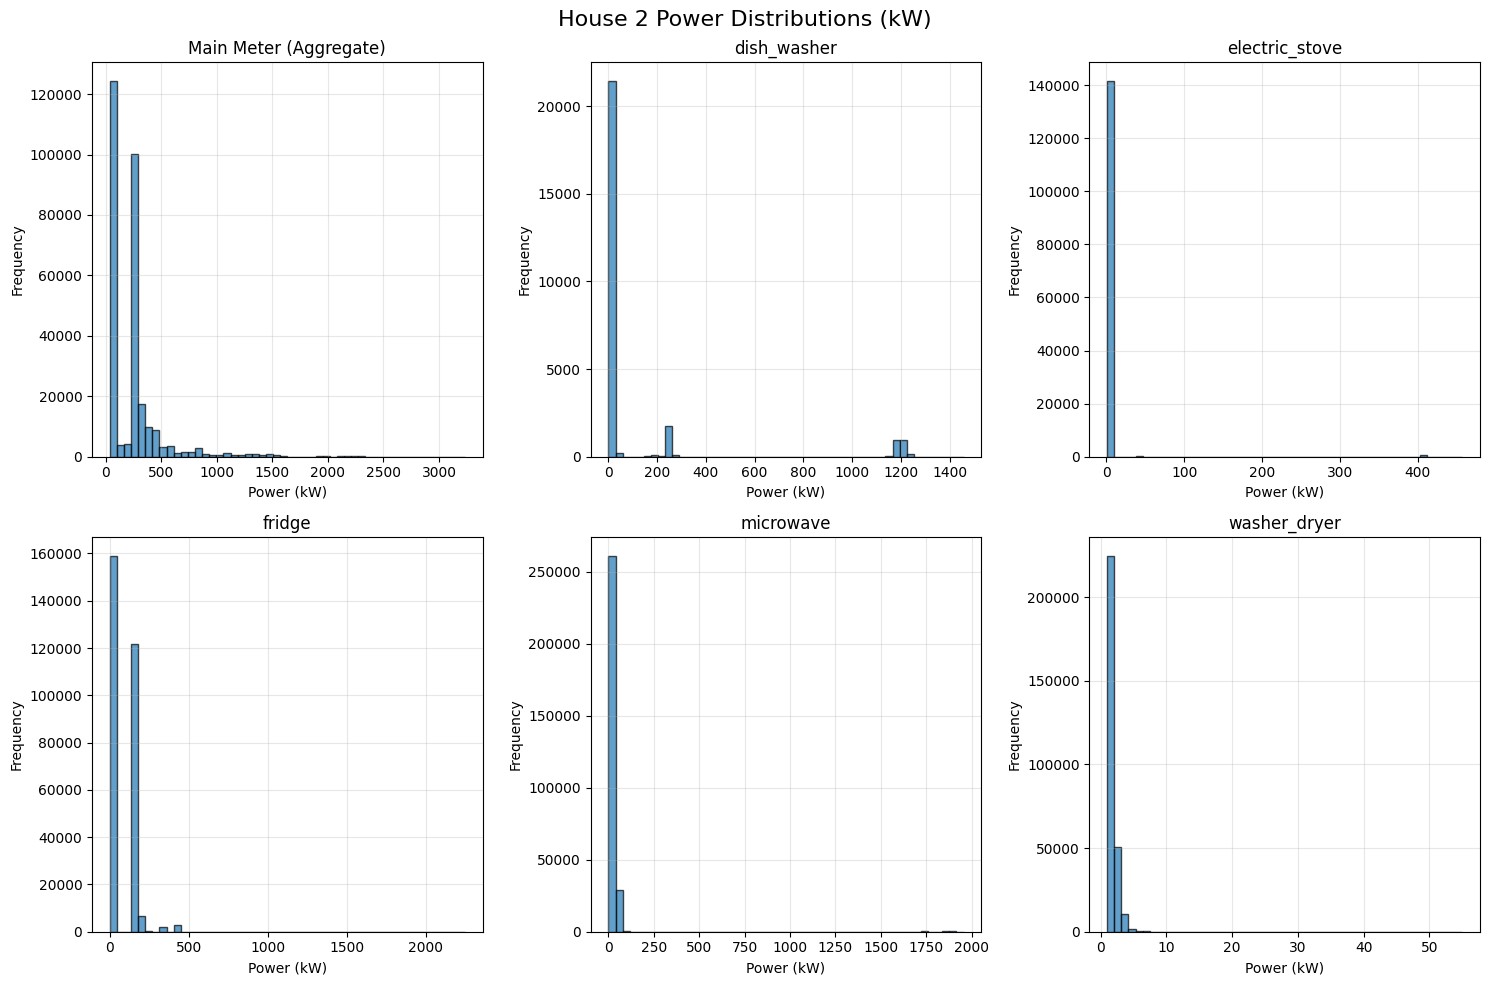


APPLIANCE BEHAVIOR ANALYSIS

dish_washer         :
  ON samples: 25,833 (8.8%)
  Power when ON: 121.878 ± 333.669 kW
  Power range: [1.000, 1457.000] kW
  Within expected window [1.200, 1.800] kW: 0.0%

electric_stove      :
  ON samples: 142,670 (48.8%)
  Power when ON: 3.309 ± 29.564 kW
  Power range: [1.000, 457.000] kW
  Within expected window [1.500, 3.500] kW: 2.3%

fridge              :
  ON samples: 292,052 (100.0%)
  Power when ON: 81.723 ± 88.498 kW
  Power range: [1.000, 2246.000] kW
  Within expected window [0.100, 0.300] kW: 0.0%

microwave           :
  ON samples: 292,062 (100.0%)
  Power when ON: 16.394 ± 117.734 kW
  Power range: [1.000, 1956.000] kW
  Within expected window [0.800, 1.200] kW: 0.0%

washer_dryer        :
  ON samples: 288,456 (98.8%)
  Power when ON: 2.214 ± 0.679 kW
  Power range: [1.000, 55.000] kW
  Within expected window [2.000, 5.000] kW: 93.2%

DATA-DRIVEN POWER WINDOWS
dish_washer         : Data-driven window [1.000 kW, 1191.000 kW]
  Data: min


Enter choice (1 or 2):  2



Using DATA-DRIVEN power windows (kW):
  dish_washer         : [1.000 kW, 1191.000 kW]
  electric_stove      : [1.000 kW, 1.010 kW]
  fridge              : [6.000 kW, 175.000 kW]
  microwave           : [4.000 kW, 45.000 kW]
  washer_dryer        : [1.000 kW, 3.000 kW]


In [6]:
# Load data 
print("\n" + "="*80)
print("LOADING HOUSE 2 DATA")
print("="*80)

loader = REDDDataLoaderHouse2(DATA_PATH, ConfigHouse2.HOUSE_NUMBER)
df_house2 = loader.load_house_data()

# Plot distributions
fig = plot_power_distributions(df_house2, "House 2 Power Distributions (kW)")
plt.savefig(os.path.join(OUTPUT_PATH, 'house2_power_distributions.png'))
plt.show()

# Analyze appliance behavior
appliance_results = analyze_appliance_behavior(df_house2)

# Create adaptive windows based on actual data
print("\n" + "="*80)
print("DATA-DRIVEN POWER WINDOWS")
print("="*80)

adaptive_windows = {}
for appliance in ConfigHouse2.SELECTED_APPLIANCES:
    if appliance in df_house2.columns:
        # Get non-zero values (> 0.01 kW = 10W)
        non_zero = df_house2[df_house2[appliance] > 0.01][appliance]
        
        if len(non_zero) > 10:
            # Use percentiles for adaptive windows
            lower = np.percentile(non_zero, 5)  # 5th percentile
            upper = np.percentile(non_zero, 95)  # 95th percentile
            
            # Ensure reasonable bounds
            lower = max(0.01, round(lower * 100) / 100)  # Round to 0.01 kW
            upper = max(lower + 0.01, round(upper * 100) / 100)
            
            adaptive_windows[appliance] = (float(lower), float(upper))
            
            print(f"{appliance:20s}: Data-driven window [{lower:.3f} kW, {upper:.3f} kW]")
            print(f"  Data: min={non_zero.min():.3f} kW, max={non_zero.max():.3f} kW, "
                  f"mean={non_zero.mean():.3f} kW")
        else:
            print(f"{appliance:20s}: Not enough non-zero samples ({len(non_zero)})")
            # Use default window
            if appliance in ConfigHouse2.POWER_WINDOWS:
                adaptive_windows[appliance] = ConfigHouse2.POWER_WINDOWS[appliance]

# Let user choose windows
print("\n" + "="*80)
print("WINDOW SELECTION")
print("="*80)
print("Choose power windows:")
print("1. Theoretical windows (from appliance specs)")
print("2. Data-driven windows (based on actual data)")

choice = input("\nEnter choice (1 or 2): ").strip()

if choice == "2":
    chosen_windows = adaptive_windows
    print("\nUsing DATA-DRIVEN power windows (kW):")
else:
    chosen_windows = ConfigHouse2.POWER_WINDOWS
    print("\nUsing THEORETICAL power windows (kW):")

for appliance, (lower, upper) in chosen_windows.items():
    print(f"  {appliance:20s}: [{lower:.3f} kW, {upper:.3f} kW]")

# ML PIPELINE

In [7]:
def run_corrected_experiment(df, power_windows, threshold=20, test_size=0.2, random_state=42):
    """Run complete experiment pipeline - CORRECTED"""
    print("\n" + "="*80)
    print(f"EXPERIMENT: Threshold={threshold}")
    print("="*80)
    
    # Step 1: Create appliance states
    df_states = create_appliance_states_corrected(df, power_windows, verbose=True)
    
    # Step 2: Create multiclass labels
    X, y, label_encoder, df_filtered = create_multiclass_labels_corrected(
        df_states, list(power_windows.keys()), threshold=threshold, verbose=True
    )
    
    # Check if we have enough classes
    n_classes = len(np.unique(y))
    if n_classes < 2:
        print(f"ERROR: Only {n_classes} class(es). Need at least 2.")
        return None
    
    # Step 3: Plot class distribution
    unique_classes, class_counts = np.unique(y, return_counts=True)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Bar plot
    class_labels = [label_encoder.inverse_transform([cls])[0] for cls in unique_classes]
    bars = ax1.bar(range(len(unique_classes)), class_counts)
    ax1.set_xlabel('Class (Binary Combination)')
    ax1.set_ylabel('Number of Samples')
    ax1.set_title('Class Distribution')
    ax1.set_xticks(range(len(unique_classes)))
    ax1.set_xticklabels(class_labels, rotation=45, ha='right', fontsize=8)
    
    # Add counts on bars
    for bar, count in zip(bars, class_counts):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{count:,}', ha='center', va='bottom', fontsize=8)
    
    # Pie chart (top 10 classes)
    top_n = min(10, len(class_counts))
    top_indices = np.argsort(class_counts)[-top_n:]
    top_counts = class_counts[top_indices]
    top_labels = [class_labels[i] for i in top_indices]
    
    ax2.pie(top_counts, labels=top_labels, autopct='%1.1f%%', startangle=90)
    ax2.set_title(f'Top {top_n} Classes')
    
    plt.suptitle(f'Class Distribution - Threshold={threshold}', fontsize=14)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_PATH, f'house2_class_distribution_th{threshold}.png'))
    plt.show()
    
    # Step 4: Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    print(f"\nData Split:")
    print(f"  Training samples: {len(X_train):,}")
    print(f"  Testing samples: {len(X_test):,}")
    print(f"  Number of classes: {n_classes}")
    print(f"  Feature dimension: {X.shape[1]}")
    print(f"  Feature range: [{X.min():.3f}, {X.max():.3f}] kW")
    
    # Step 5: Train and evaluate classifiers
    classifiers = {
        'CART': DecisionTreeClassifier(max_depth=10, random_state=random_state),
        'RF': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=random_state, n_jobs=-1),
        'ET': ExtraTreesClassifier(n_estimators=100, max_depth=10, random_state=random_state, n_jobs=-1),
        'KNN': KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
        'KNN-CB': KNeighborsClassifier(n_neighbors=10, weights='distance', n_jobs=-1),
        'LDA': LinearDiscriminantAnalysis(),
        'NB': GaussianNB()
    }
    
    results = {}
    
    for name, clf in classifiers.items():
        try:
            print(f"\nTraining {name}...")
            start_time = time.time()
            
            # Scale features
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            
            # Train
            clf.fit(X_train_scaled, y_train)
            train_time = time.time() - start_time
            
            # Predict
            y_pred = clf.predict(X_test_scaled)
            
            # Calculate metrics
            results[name] = {
                'accuracy': accuracy_score(y_test, y_pred),
                'precision_macro': precision_score(y_test, y_pred, average='macro', zero_division=0),
                'recall_macro': recall_score(y_test, y_pred, average='macro', zero_division=0),
                'f1_macro': f1_score(y_test, y_pred, average='macro', zero_division=0),
                'precision_weighted': precision_score(y_test, y_pred, average='weighted', zero_division=0),
                'recall_weighted': recall_score(y_test, y_pred, average='weighted', zero_division=0),
                'f1_weighted': f1_score(y_test, y_pred, average='weighted', zero_division=0),
                'train_time': train_time,
                'n_classes': n_classes
            }
            
            print(f"  ✓ Accuracy: {results[name]['accuracy']:.4f}")
            print(f"  ✓ Macro F1: {results[name]['f1_macro']:.4f}")
            print(f"  ✓ Weighted F1: {results[name]['f1_weighted']:.4f}")
            print(f"  ✓ Time: {train_time:.2f}s")
            
        except Exception as e:
            print(f"  ✗ Error: {e}")
            results[name] = None
    
    return results, df_filtered, label_encoder

# RUN EXPERIMENTS


RUNNING CORRECTED EXPERIMENTS

################################################################################
RUNNING EXPERIMENT WITH THRESHOLD = 5
################################################################################

EXPERIMENT: Threshold=5

CREATING APPLIANCE STATES (Corrected)
dish_washer         :  24,551 ON samples (8.4%)
  Window: [1.000 kW, 1191.000 kW]
electric_stove      : 137,475 ON samples (47.1%)
  Window: [1.000 kW, 1.010 kW]
fridge              : 276,713 ON samples (94.7%)
  Window: [6.000 kW, 175.000 kW]
microwave           : 279,486 ON samples (95.7%)
  Window: [4.000 kW, 45.000 kW]
washer_dryer        : 275,381 ON samples (94.3%)
  Window: [1.000 kW, 3.000 kW]

Thresholding Analysis (Threshold = 5):
Total samples: 292,063
Unique combinations: 30
Valid combinations (≥5): 29
Samples after thresholding: 292,062 (100.0%)

Top 10 Appliance Combinations:
  01111: dis:OFF | ele:ON | fri:ON | mic:ON | was:ON - 115,703 samples
  00111: dis:OFF | ele:OFF | fri:ON 

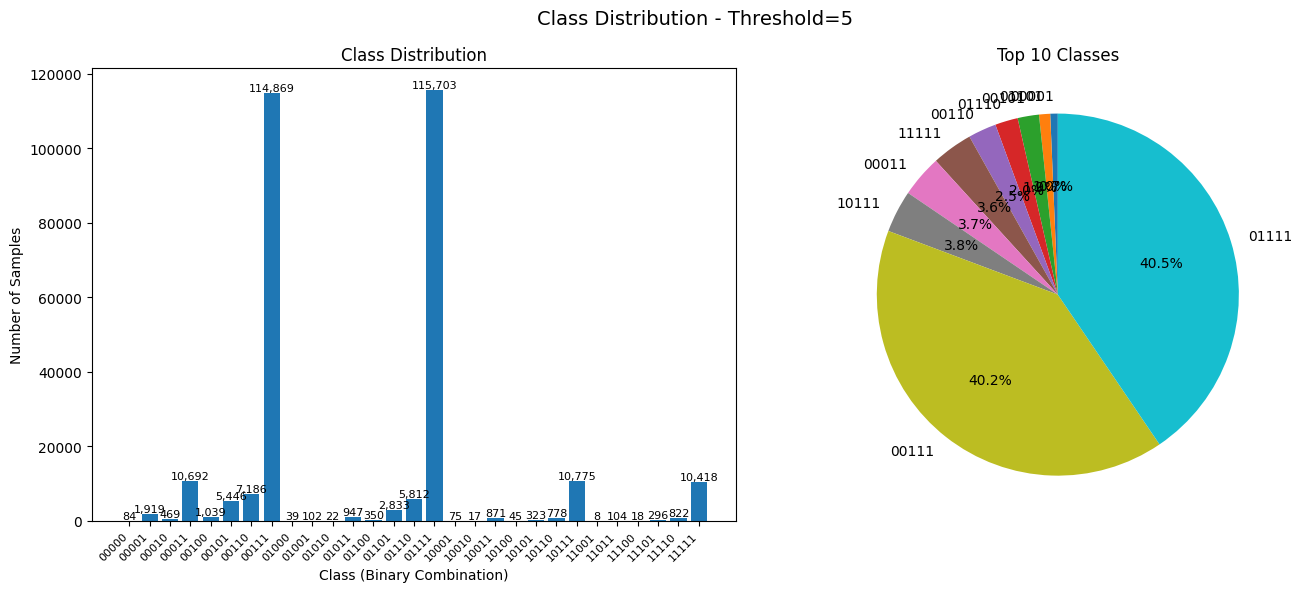


Data Split:
  Training samples: 233,649
  Testing samples: 58,413
  Number of classes: 29
  Feature dimension: 1
  Feature range: [36.360, 3232.980] kW

Training CART...
  ✓ Accuracy: 0.7173
  ✓ Macro F1: 0.2052
  ✓ Weighted F1: 0.6711
  ✓ Time: 0.30s

Training RF...
  ✓ Accuracy: 0.7189
  ✓ Macro F1: 0.2062
  ✓ Weighted F1: 0.6719
  ✓ Time: 9.38s

Training ET...
  ✓ Accuracy: 0.7124
  ✓ Macro F1: 0.1680
  ✓ Weighted F1: 0.6537
  ✓ Time: 2.25s

Training KNN...
  ✓ Accuracy: 0.6817
  ✓ Macro F1: 0.2430
  ✓ Weighted F1: 0.6544
  ✓ Time: 0.10s

Training KNN-CB...
  ✓ Accuracy: 0.6970
  ✓ Macro F1: 0.3133
  ✓ Weighted F1: 0.6718
  ✓ Time: 0.10s

Training LDA...
  ✓ Accuracy: 0.6845
  ✓ Macro F1: 0.0832
  ✓ Weighted F1: 0.6145
  ✓ Time: 0.09s

Training NB...
  ✓ Accuracy: 0.6782
  ✓ Macro F1: 0.0735
  ✓ Weighted F1: 0.6104
  ✓ Time: 0.04s

Results saved to: /kaggle/working/house2_results/house2_corrected_results_th5.pkl

#####################################################################

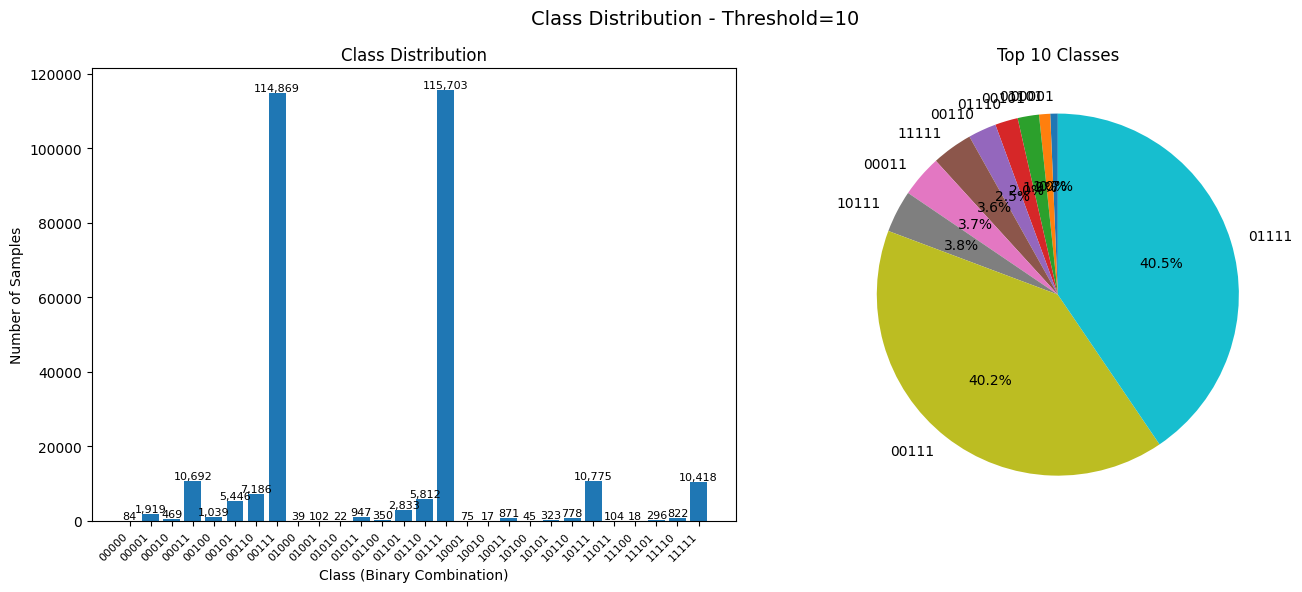


Data Split:
  Training samples: 233,643
  Testing samples: 58,411
  Number of classes: 28
  Feature dimension: 1
  Feature range: [36.360, 3232.980] kW

Training CART...
  ✓ Accuracy: 0.7173
  ✓ Macro F1: 0.2132
  ✓ Weighted F1: 0.6711
  ✓ Time: 0.30s

Training RF...
  ✓ Accuracy: 0.7186
  ✓ Macro F1: 0.2022
  ✓ Weighted F1: 0.6715
  ✓ Time: 9.37s

Training ET...
  ✓ Accuracy: 0.7125
  ✓ Macro F1: 0.1800
  ✓ Weighted F1: 0.6538
  ✓ Time: 2.22s

Training KNN...
  ✓ Accuracy: 0.6854
  ✓ Macro F1: 0.2327
  ✓ Weighted F1: 0.6578
  ✓ Time: 0.10s

Training KNN-CB...
  ✓ Accuracy: 0.6987
  ✓ Macro F1: 0.2955
  ✓ Weighted F1: 0.6728
  ✓ Time: 0.10s

Training LDA...
  ✓ Accuracy: 0.6846
  ✓ Macro F1: 0.0862
  ✓ Weighted F1: 0.6145
  ✓ Time: 0.09s

Training NB...
  ✓ Accuracy: 0.6783
  ✓ Macro F1: 0.0761
  ✓ Weighted F1: 0.6104
  ✓ Time: 0.04s

Results saved to: /kaggle/working/house2_results/house2_corrected_results_th10.pkl

####################################################################

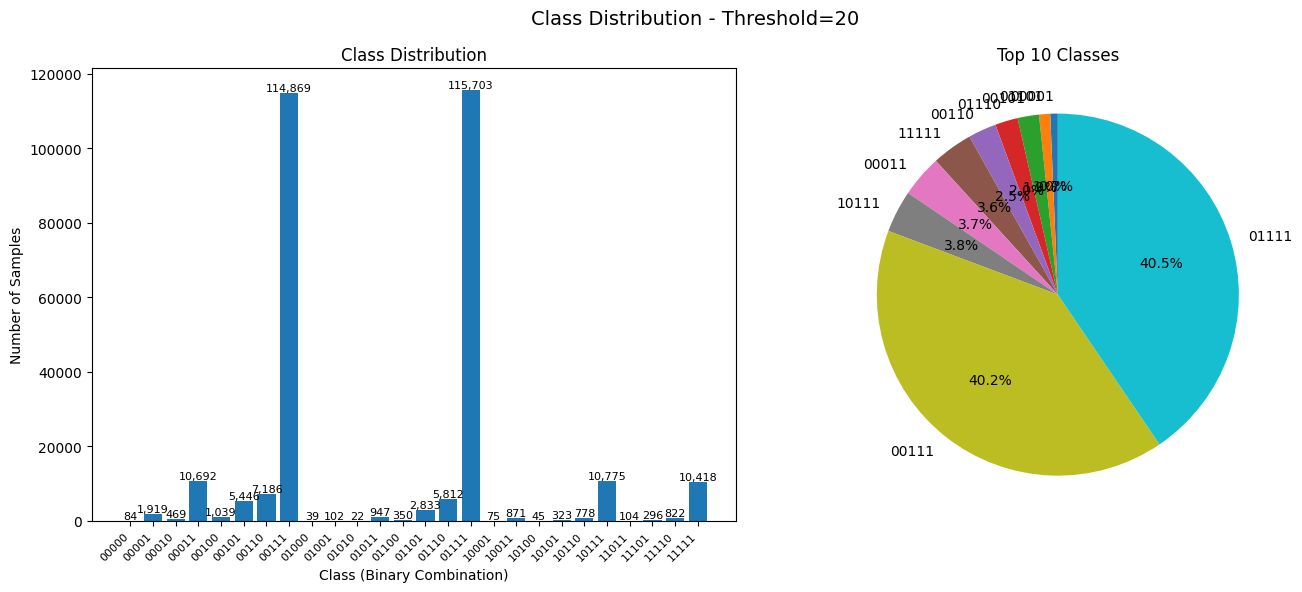


Data Split:
  Training samples: 233,615
  Testing samples: 58,404
  Number of classes: 26
  Feature dimension: 1
  Feature range: [36.360, 3232.980] kW

Training CART...
  ✓ Accuracy: 0.7174
  ✓ Macro F1: 0.2197
  ✓ Weighted F1: 0.6716
  ✓ Time: 0.30s

Training RF...
  ✓ Accuracy: 0.7189
  ✓ Macro F1: 0.2203
  ✓ Weighted F1: 0.6719
  ✓ Time: 9.31s

Training ET...
  ✓ Accuracy: 0.7125
  ✓ Macro F1: 0.1761
  ✓ Weighted F1: 0.6535
  ✓ Time: 2.25s

Training KNN...
  ✓ Accuracy: 0.6819
  ✓ Macro F1: 0.2469
  ✓ Weighted F1: 0.6544
  ✓ Time: 0.10s

Training KNN-CB...
  ✓ Accuracy: 0.6988
  ✓ Macro F1: 0.3128
  ✓ Weighted F1: 0.6735
  ✓ Time: 0.10s

Training LDA...
  ✓ Accuracy: 0.6846
  ✓ Macro F1: 0.0933
  ✓ Weighted F1: 0.6146
  ✓ Time: 0.09s

Training NB...
  ✓ Accuracy: 0.6783
  ✓ Macro F1: 0.0821
  ✓ Weighted F1: 0.6105
  ✓ Time: 0.04s

Results saved to: /kaggle/working/house2_results/house2_corrected_results_th20.pkl

####################################################################

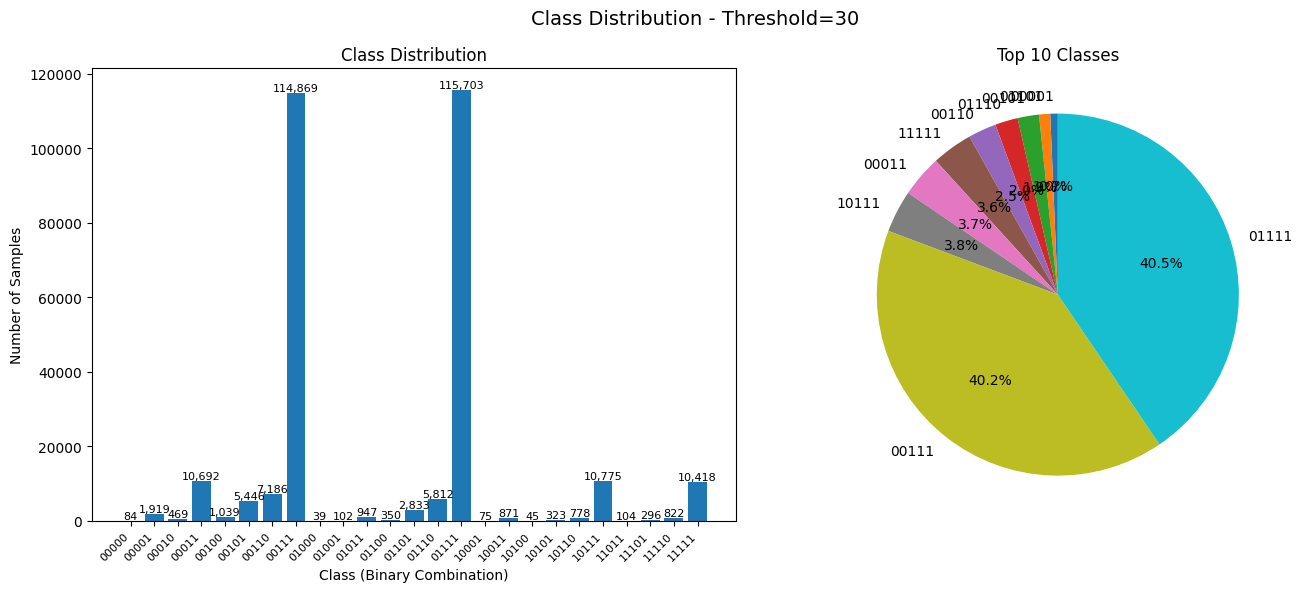


Data Split:
  Training samples: 233,597
  Testing samples: 58,400
  Number of classes: 25
  Feature dimension: 1
  Feature range: [36.360, 3232.980] kW

Training CART...
  ✓ Accuracy: 0.7182
  ✓ Macro F1: 0.2351
  ✓ Weighted F1: 0.6721
  ✓ Time: 0.33s

Training RF...
  ✓ Accuracy: 0.7192
  ✓ Macro F1: 0.2279
  ✓ Weighted F1: 0.6722
  ✓ Time: 9.25s

Training ET...
  ✓ Accuracy: 0.7131
  ✓ Macro F1: 0.1822
  ✓ Weighted F1: 0.6541
  ✓ Time: 2.22s

Training KNN...
  ✓ Accuracy: 0.6869
  ✓ Macro F1: 0.2707
  ✓ Weighted F1: 0.6599
  ✓ Time: 0.10s

Training KNN-CB...
  ✓ Accuracy: 0.6990
  ✓ Macro F1: 0.3367
  ✓ Weighted F1: 0.6732
  ✓ Time: 0.10s

Training LDA...
  ✓ Accuracy: 0.6853
  ✓ Macro F1: 0.0954
  ✓ Weighted F1: 0.6153
  ✓ Time: 0.09s

Training NB...
  ✓ Accuracy: 0.6791
  ✓ Macro F1: 0.0855
  ✓ Weighted F1: 0.6112
  ✓ Time: 0.04s

Results saved to: /kaggle/working/house2_results/house2_corrected_results_th30.pkl

####################################################################

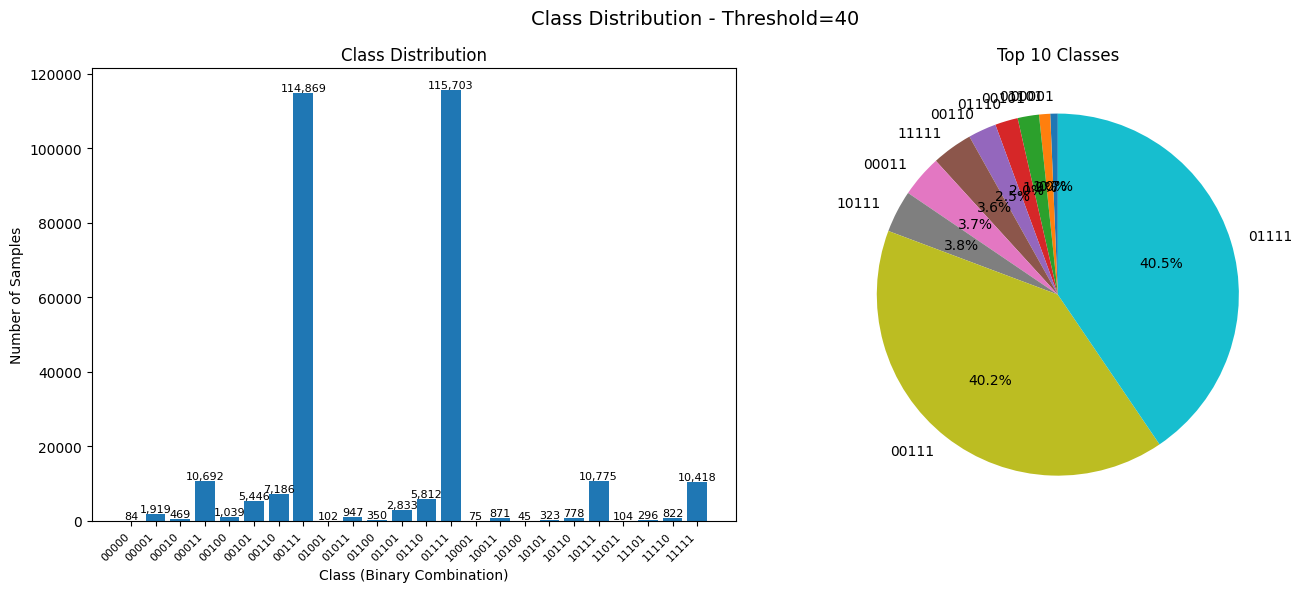


Data Split:
  Training samples: 233,566
  Testing samples: 58,392
  Number of classes: 24
  Feature dimension: 1
  Feature range: [36.360, 3232.980] kW

Training CART...
  ✓ Accuracy: 0.7181
  ✓ Macro F1: 0.2306
  ✓ Weighted F1: 0.6719
  ✓ Time: 0.30s

Training RF...
  ✓ Accuracy: 0.7193
  ✓ Macro F1: 0.2277
  ✓ Weighted F1: 0.6725
  ✓ Time: 9.12s

Training ET...
  ✓ Accuracy: 0.7130
  ✓ Macro F1: 0.1877
  ✓ Weighted F1: 0.6540
  ✓ Time: 2.23s

Training KNN...
  ✓ Accuracy: 0.6840
  ✓ Macro F1: 0.2687
  ✓ Weighted F1: 0.6571
  ✓ Time: 0.10s

Training KNN-CB...
  ✓ Accuracy: 0.6969
  ✓ Macro F1: 0.3305
  ✓ Weighted F1: 0.6712
  ✓ Time: 0.10s

Training LDA...
  ✓ Accuracy: 0.6855
  ✓ Macro F1: 0.0979
  ✓ Weighted F1: 0.6154
  ✓ Time: 0.09s

Training NB...
  ✓ Accuracy: 0.6792
  ✓ Macro F1: 0.0892
  ✓ Weighted F1: 0.6113
  ✓ Time: 0.04s

Results saved to: /kaggle/working/house2_results/house2_corrected_results_th40.pkl

####################################################################

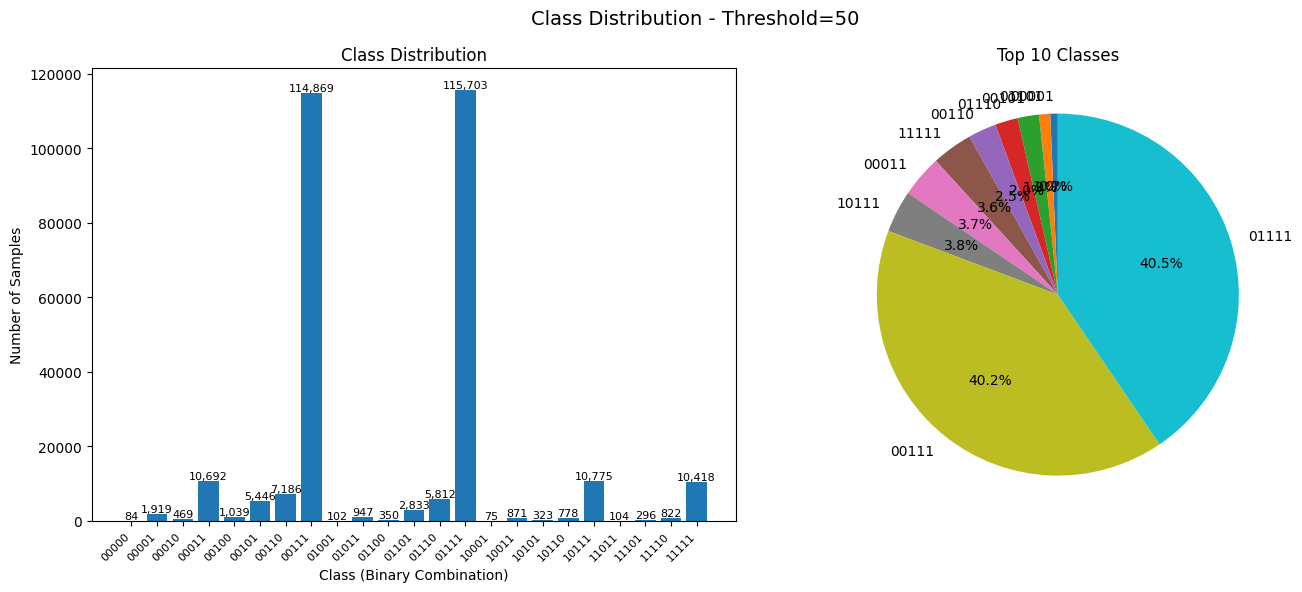


Data Split:
  Training samples: 233,530
  Testing samples: 58,383
  Number of classes: 23
  Feature dimension: 1
  Feature range: [36.360, 3232.980] kW

Training CART...
  ✓ Accuracy: 0.7177
  ✓ Macro F1: 0.2327
  ✓ Weighted F1: 0.6713
  ✓ Time: 0.29s

Training RF...
  ✓ Accuracy: 0.7193
  ✓ Macro F1: 0.2381
  ✓ Weighted F1: 0.6724
  ✓ Time: 9.17s

Training ET...
  ✓ Accuracy: 0.7132
  ✓ Macro F1: 0.2014
  ✓ Weighted F1: 0.6544
  ✓ Time: 2.16s

Training KNN...
  ✓ Accuracy: 0.6828
  ✓ Macro F1: 0.2687
  ✓ Weighted F1: 0.6568
  ✓ Time: 0.10s

Training KNN-CB...
  ✓ Accuracy: 0.6984
  ✓ Macro F1: 0.3248
  ✓ Weighted F1: 0.6730
  ✓ Time: 0.10s

Training LDA...
  ✓ Accuracy: 0.6856
  ✓ Macro F1: 0.1025
  ✓ Weighted F1: 0.6155
  ✓ Time: 0.08s

Training NB...
  ✓ Accuracy: 0.6793
  ✓ Macro F1: 0.0934
  ✓ Weighted F1: 0.6114
  ✓ Time: 0.03s

Results saved to: /kaggle/working/house2_results/house2_corrected_results_th50.pkl


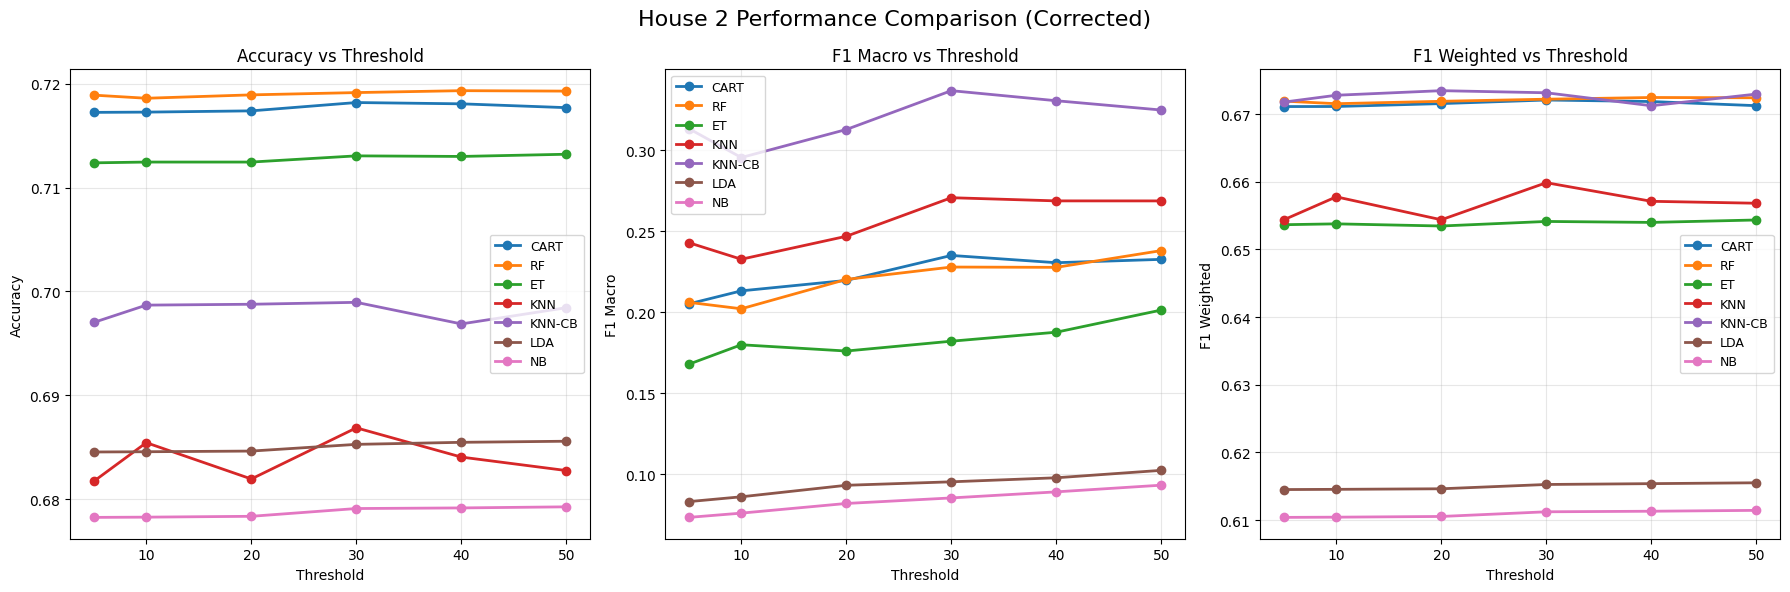


EXPERIMENT SUMMARY (CORRECTED)
Threshold  Samples      Classes    Best Classifier Best Macro F1   Best Acc  
--------------------------------------------------------------------------------
5          292,062      29         KNN-CB          0.3133          0.6970    
10         292,054      28         KNN-CB          0.2955          0.6987    
20         292,019      26         KNN-CB          0.3128          0.6988    
30         291,997      25         KNN-CB          0.3367          0.6990    
40         291,958      24         KNN-CB          0.3305          0.6969    
50         291,913      23         KNN-CB          0.3248          0.6984    

EXPERIMENT COMPLETE!

All results saved to: /kaggle/working/house2_results/

Generated files:
  house2_class_distribution_th10.png
  house2_class_distribution_th20.png
  house2_class_distribution_th30.png
  house2_class_distribution_th40.png
  house2_class_distribution_th5.png
  house2_class_distribution_th50.png
  house2_corrected_result

In [8]:
def main_corrected_experiment(df, windows):
    """Main experiment with corrected data"""
    
    # Run experiments with different thresholds
    all_results = {}
    thresholds_to_test = ConfigHouse2.THRESHOLDS
    
    for threshold in thresholds_to_test:
        print(f"\n{'#'*80}")
        print(f"RUNNING EXPERIMENT WITH THRESHOLD = {threshold}")
        print(f"{'#'*80}")
        
        try:
            results, df_filtered, label_encoder = run_corrected_experiment(
                df, 
                windows, 
                threshold=threshold,
                test_size=ConfigHouse2.TEST_SIZE,
                random_state=ConfigHouse2.RANDOM_STATE
            )
            
            if results:
                all_results[threshold] = (results, df_filtered, label_encoder)
                
                # Save results
                results_file = os.path.join(OUTPUT_PATH, f'house2_corrected_results_th{threshold}.pkl')
                joblib.dump({
                    'threshold': threshold,
                    'results': results,
                    'label_encoder': label_encoder,
                    'n_samples': len(df_filtered),
                    'n_classes': len(np.unique(df_filtered['label']))
                }, results_file)
                print(f"\nResults saved to: {results_file}")
                
        except Exception as e:
            print(f"Error running experiment with threshold={threshold}: {e}")
            continue
    
    # Plot comparison across thresholds
    if all_results:
        # Create comparison plot
        classifiers = ['CART', 'RF', 'ET', 'KNN', 'KNN-CB', 'LDA', 'NB']
        metrics = ['accuracy', 'f1_macro', 'f1_weighted']
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        for idx, metric in enumerate(metrics):
            ax = axes[idx]
            
            for clf in classifiers:
                values = []
                for th in thresholds_to_test:
                    if th in all_results and all_results[th] and clf in all_results[th][0]:
                        if all_results[th][0][clf]:
                            values.append(all_results[th][0][clf][metric])
                        else:
                            values.append(np.nan)
                    else:
                        values.append(np.nan)
                
                ax.plot(thresholds_to_test, values, marker='o', label=clf, linewidth=2)
            
            ax.set_xlabel('Threshold')
            ax.set_ylabel(metric.replace('_', ' ').title())
            ax.set_title(f'{metric.replace("_", " ").title()} vs Threshold')
            ax.grid(True, alpha=0.3)
            ax.legend(fontsize=9)
        
        plt.suptitle('House 2 Performance Comparison (Corrected)', fontsize=16)
        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_PATH, 'house2_corrected_threshold_comparison.png'))
        plt.show()
        
        # Print summary table
        print("\n" + "="*80)
        print("EXPERIMENT SUMMARY (CORRECTED)")
        print("="*80)
        print(f"{'Threshold':<10} {'Samples':<12} {'Classes':<10} {'Best Classifier':<15} {'Best Macro F1':<15} {'Best Acc':<10}")
        print("-"*80)
        
        for th in thresholds_to_test:
            if th in all_results:
                results, df_filtered, _ = all_results[th]
                
                # Find best classifier
                best_clf = None
                best_f1 = 0
                best_acc = 0
                for clf_name, clf_results in results.items():
                    if clf_results and clf_results['f1_macro'] > best_f1:
                        best_f1 = clf_results['f1_macro']
                        best_acc = clf_results['accuracy']
                        best_clf = clf_name
                
                if best_clf:
                    print(f"{th:<10} {len(df_filtered):<12,} {len(np.unique(df_filtered['label'])):<10} "
                          f"{best_clf:<15} {best_f1:<15.4f} {best_acc:<10.4f}")
    
    return all_results

# Run the corrected experiment
print("\n" + "="*80)
print("RUNNING CORRECTED EXPERIMENTS")
print("="*80)

final_results = main_corrected_experiment(df_house2, chosen_windows)

print("\n" + "="*80)
print("EXPERIMENT COMPLETE!")
print("="*80)
print(f"\nAll results saved to: {OUTPUT_PATH}")

# List generated files
print("\nGenerated files:")
for file in sorted(os.listdir(OUTPUT_PATH)):
    if file.endswith(('.png', '.pkl')):
        print(f"  {file}")

# Additional Analysis


AGGREGATE POWER ANALYSIS BY APPLIANCE COMBINATION

00110: dis:OFF | ele:OFF | fri:ON | mic:ON | was:OFF
  Samples: 7,186
  Main power: 350.525 ± 211.702 kW
  Range: [36.870, 1924.150] kW

10110: dis:ON | ele:OFF | fri:ON | mic:ON | was:OFF
  Samples: 778
  Main power: 417.380 ± 294.666 kW
  Range: [37.440, 1501.220] kW

01110: dis:OFF | ele:ON | fri:ON | mic:ON | was:OFF
  Samples: 5,812
  Main power: 121.211 ± 196.871 kW
  Range: [36.810, 1297.090] kW

11110: dis:ON | ele:ON | fri:ON | mic:ON | was:OFF
  Samples: 822
  Main power: 129.464 ± 198.868 kW
  Range: [37.080, 1487.780] kW

00010: dis:OFF | ele:OFF | fri:OFF | mic:ON | was:OFF
  Samples: 469
  Main power: 463.735 ± 230.724 kW
  Range: [37.230, 1507.120] kW

01010: dis:OFF | ele:ON | fri:OFF | mic:ON | was:OFF
  Samples: 22
  Main power: 516.561 ± 298.770 kW
  Range: [37.140, 1368.670] kW

10010: dis:ON | ele:OFF | fri:OFF | mic:ON | was:OFF
  Samples: 17
  Main power: 597.685 ± 501.743 kW
  Range: [285.340, 1512.770] kW

001

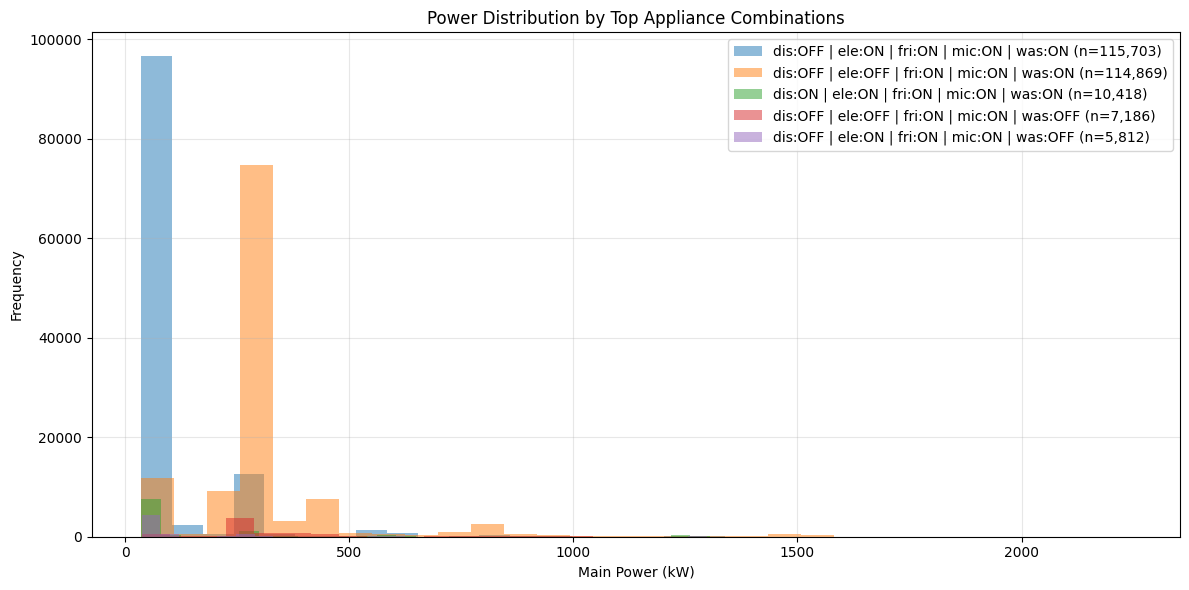

In [9]:
def analyze_feature_importance(df_states, power_windows):
    """Analyze if aggregate power can distinguish appliance states"""
    
    # Get state columns
    state_columns = [f"{app}_state" for app in power_windows.keys() 
                     if f"{app}_state" in df_states.columns]
    
    if not state_columns:
        return
    
    # Create combination
    df_states['combination'] = df_states[state_columns].astype(str).agg(''.join, axis=1)
    
    # Analyze main power for each combination
    combos = df_states['combination'].unique()
    
    print("\n" + "="*80)
    print("AGGREGATE POWER ANALYSIS BY APPLIANCE COMBINATION")
    print("="*80)
    
    power_stats = {}
    for combo in combos[:10]:  # Top 10 combinations
        mask = df_states['combination'] == combo
        main_power = df_states.loc[mask, 'main']
        
        if len(main_power) > 10:
            power_stats[combo] = {
                'count': len(main_power),
                'mean': main_power.mean(),
                'std': main_power.std(),
                'min': main_power.min(),
                'max': main_power.max()
            }
            
            # Decode binary string
            states = []
            apps = [app.replace('_state', '') for app in state_columns]
            for i, app in enumerate(apps):
                if i < len(combo):
                    state = "ON" if combo[i] == '1' else "OFF"
                    states.append(f"{app[:3]}:{state}")
            state_str = " | ".join(states)
            
            print(f"\n{combo}: {state_str}")
            print(f"  Samples: {len(main_power):,}")
            print(f"  Main power: {main_power.mean():.3f} ± {main_power.std():.3f} kW")
            print(f"  Range: [{main_power.min():.3f}, {main_power.max():.3f}] kW")
    
    return power_stats

# Run additional analysis
if 'df_house2' in locals() and 'chosen_windows' in locals():
    # Create states for analysis
    df_states_analysis = create_appliance_states_corrected(df_house2, chosen_windows, verbose=False)
    power_stats = analyze_feature_importance(df_states_analysis, chosen_windows)
    
    # Plot power distribution by top combinations
    if power_stats:
        top_combos = sorted(power_stats.items(), key=lambda x: x[1]['count'], reverse=True)[:5]
        
        fig, ax = plt.subplots(figsize=(12, 6))
        for combo, stats in top_combos:
            # Decode binary string for label
            state_columns = [f"{app}_state" for app in chosen_windows.keys()]
            apps = [app.replace('_state', '') for app in state_columns]
            states = []
            for i, app in enumerate(apps):
                if i < len(combo):
                    state = "ON" if combo[i] == '1' else "OFF"
                    states.append(f"{app[:3]}:{state}")
            label = " | ".join(states)
            
            # Plot distribution
            mask = df_states_analysis['combination'] == combo
            data = df_states_analysis.loc[mask, 'main'].values
            ax.hist(data, bins=30, alpha=0.5, label=f"{label} (n={stats['count']:,})")
        
        ax.set_xlabel('Main Power (kW)')
        ax.set_ylabel('Frequency')
        ax.set_title('Power Distribution by Top Appliance Combinations')
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_PATH, 'house2_power_by_combination.png'))
        plt.show()